In [ ]:
import pandas as pd
from dsipts import TimeSeries, RNN,Monash,get_freq


In [ ]:
m = Monash(filename='monash',baseUrl='https://forecastingdata.org/', rebuild=False)
#m.download_dataset('data',4656144,rebuild=True)
#m.save('monash')

In [ ]:
m = Monash(filename='monash',baseUrl='https://forecastingdata.org/', rebuild=False)
m.load('monash')
m.downloaded.keys()


In [ ]:

loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length = m.generate_dataset(4656144)


In [ ]:
loaded_data

In [ ]:
serie = pd.DataFrame({'signal':loaded_data.series_value.iloc[0]})
serie['time'] = pd.date_range(start = loaded_data.start_timestamp.iloc[0], periods=  serie.shape[0],freq=get_freq(frequency))
serie['cum'] = serie.time.dt.minute  + serie.time.dt.hour 
starting_point = {'cum':0} ##this can be used for creating the dataset: only samples with cum=0 in the first future lag will be used as samples! 
ts = TimeSeries('4656144')
ts.load_signal(serie.iloc[0:8000],enrich_cat=['dow','hour'],target_variables=['signal'])

In [ ]:
ts.plot();

In [ ]:
past_steps = 100
future_steps = 20
config = dict(model_configs =dict(
                                    cat_emb_dim = 16,
                                    kind = 'gru',
                                    hidden_RNN = 12,
                                    num_layers_RNN = 2,
                                    sum_emb = True,
                                    kernel_size = 15,
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                                    past_channels = len(ts.num_var),
                                    future_channels = len(ts.future_variables),
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                    quantiles=[0.1,0.5,0.9],
                                    dropout_rate= 0.5,
                                    persistence_weight= 0.010,
                                    loss_type= 'l1',
                                    remove_last= True,
                                    use_bn = False,
                                    optim= 'torch.optim.Adam',
                                    activation= 'torch.nn.PReLU',                            
                                    out_channels = len(ts.target_variables)),
                scheduler_config = dict(gamma=0.1,step_size=100),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model_sum = RNN(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'] )
ts.set_model(model_sum,config=config )

In [ ]:
ts.set_model(model_sum,config=config )

In [ ]:
ts.train_model(dirpath="/home/agobbi/Projects/TT/tmp/4656719v2",split_params=dict(perc_train=0.6, perc_valid=0.2,past_steps = past_steps,future_steps=future_steps, range_train=None, range_validation=None, range_test=None,shift = 0,starting_point=None,skip_step=1),batch_size=100,num_workers=4,max_epochs=40,auto_lr_find=True,devices='auto')

In [ ]:
ts.scaler_cat

In [ ]:
ts.losses.plot()

In [ ]:
ts.modifier=None

In [ ]:
res = ts.inference_on_set(batch_size = 100,num_workers = 4)

In [ ]:
import numpy as np
np.sqrt(np.mean((res[res.lag==2]['signal_median'] - res[res.lag==2].signal)**2))

In [ ]:
%matplotlib qt
res[res.lag==2].drop(columns='time').plot()

In [ ]:
from datetime import timedelta
res['prediction_time'] = res.apply(lambda x: x.time-timedelta(minutes=60*x.lag), axis=1)

In [ ]:
import matplotlib.pyplot as plt
date = '2006-02-15 02:20:01'

mask = res.prediction_time==date
plt.plot(res.lag[mask],res.signal[mask],label='real')
plt.plot(res.lag[mask],res.signal_median[mask],label='median')
plt.legend()

In [ ]:
ts.save('tmp')

In [4]:
import pandas as pd
from dsipts import TimeSeries, RNN,Monash,get_freq
import numpy as np
import matplotlib.pyplot as plt
ts = TimeSeries('4656144')
ts.load(RNN,'tmp',load_last=False)

/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
l = ts.dataset.shape[0]
perc_train = 0.6
perc_valid = 0.2
train = ts.dataset.iloc[0:int(perc_train*l)]
validation = ts.dataset.iloc[int(perc_train*l):int(perc_train*l+perc_valid*l)]
test = ts.dataset.iloc[int(perc_train*l+perc_valid*l):]

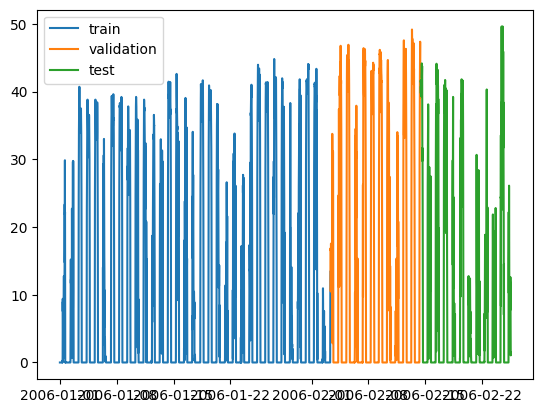

In [6]:
plt.plot(train.time, train.signal,label='train')
plt.plot(validation.time, validation.signal,label='validation')
plt.plot(test.time, test.signal,label='test')
plt.legend()

In [7]:
ts.split_params

{'perc_train': 0.6,
 'perc_valid': 0.2,
 'past_steps': 100,
 'future_steps': 20,
 'range_train': None,
 'range_validation': None,
 'range_test': None,
 'shift': 0,
 'starting_point': None,
 'skip_step': 1}

In [8]:

res_orig = ts.inference_on_set(batch_size = 100,num_workers = 4)

In [9]:
m = Monash(filename='monash',baseUrl='https://forecastingdata.org/', rebuild=False)
m.load('monash')
loaded_data,frequency,forecast_horizon,contain_missing_values,contain_equal_length = m.generate_dataset(4656144)


serie = pd.DataFrame({'signal':loaded_data.series_value.iloc[0]})
serie['time'] = pd.date_range(start = loaded_data.start_timestamp.iloc[0], periods=  serie.shape[0],freq=get_freq(frequency))
serie['cum'] = serie.time.dt.minute  + serie.time.dt.hour 
starting_point = {'cum':0}


In [26]:
serie

,signal,time,cum
0,0.0,2006-01-01 00:00:01,0
1,0.0,2006-01-01 00:10:01,10
2,0.0,2006-01-01 00:20:01,20
3,0.0,2006-01-01 00:30:01,30
4,0.0,2006-01-01 00:40:01,40
...,...,...,...
52555,0.0,2006-12-31 23:10:01,33
52556,0.0,2006-12-31 23:20:01,43
52557,0.0,2006-12-31 23:30:01,53
52558,0.0,2006-12-31 23:40:01,63


In [18]:
res = ts.inference(batch_size = 100,num_workers = 4,data=ts.dataset,steps_in_future=100)
res

,lag,time,signal,signal_low,signal_median,signal_high
0,1,2006-01-01 16:40:01,-2.009074e-07,-0.817537,-0.000366,5.168141
1,1,2006-01-01 16:50:01,-2.009074e-07,-0.515006,-0.000368,4.710861
2,1,2006-01-01 17:00:01,-2.009074e-07,-0.416238,-0.000369,4.350452
3,1,2006-01-01 17:10:01,-2.009074e-07,-0.349064,-0.000367,4.115104
4,1,2006-01-01 17:20:01,-2.009074e-07,-0.306284,-0.000365,3.967124
...,...,...,...,...,...,...
157615,20,2006-02-25 12:30:01,6.800000e+00,-2.239187,1.749822,10.667901
157616,20,2006-02-25 12:40:01,4.850000e+00,0.974250,5.699834,15.084847
157617,20,2006-02-25 12:50:01,2.900000e+00,1.278800,6.899848,16.860020
157618,20,2006-02-25 13:00:01,1.050000e+00,2.586636,7.849844,17.594950


In [12]:
%matplotlib qt
plt.plot(res.time[(res.lag==1)],res.signal_median[(res.lag==1)],label='all')
plt.plot(res_orig.time[(res_orig.lag==1)],res_orig.signal_median[(res_orig.lag==1)],label='test')
plt.legend()

In [ ]:
res[res.time>res_orig.time.max()]

KeyError: 'median'

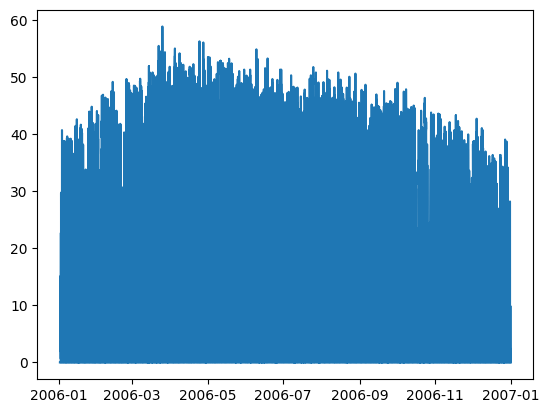

In [6]:
import matplotlib.pyplot as plt
res.sort_values(by='time',inplace=True)
plt.plot(res.time, res['signal'],label='real')
plt.plot(res.time, res['median'],label='median')

In [ ]:
res['error'] =np.abs( res['signal']-res['signal_median'])
res.groupby('lag').error.mean().plot()